# ML Individual Project - Transfer Learning with VGG16
## by Amy Reidy

Loading necessary libaries and packages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import random
import math
import cv2
import os
import shutil
from google.colab import files
import pathlib
np.random.seed(101)


%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#import all vgg16 packages
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

Loading data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data/images.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

Exploring Data

In [ ]:
img = tf.keras.preprocessing.image.load_img('train/5/00005_00053_00010.png')
img

In [ ]:
train_path = 'Train'
test_path = 'Test'

In [ ]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [ ]:
train_df = pd.read_csv('Train.csv')
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


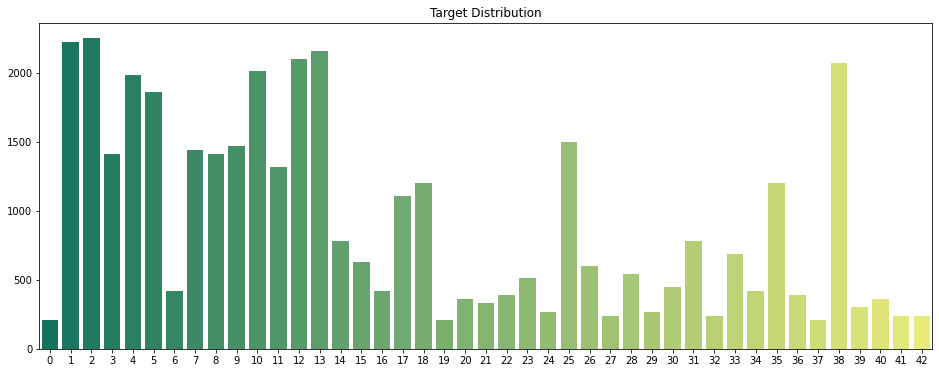

In [ ]:
# Counting target values.

targ_cts=train_df.ClassId.value_counts()    #target name
fig = plt.figure(figsize=(16,6))
sns.barplot(x=targ_cts.sort_values(ascending=False).index, 
            y=targ_cts.sort_values(ascending=False).values, 
            palette='summer')
plt.title('Target Distribution')
plt.show()

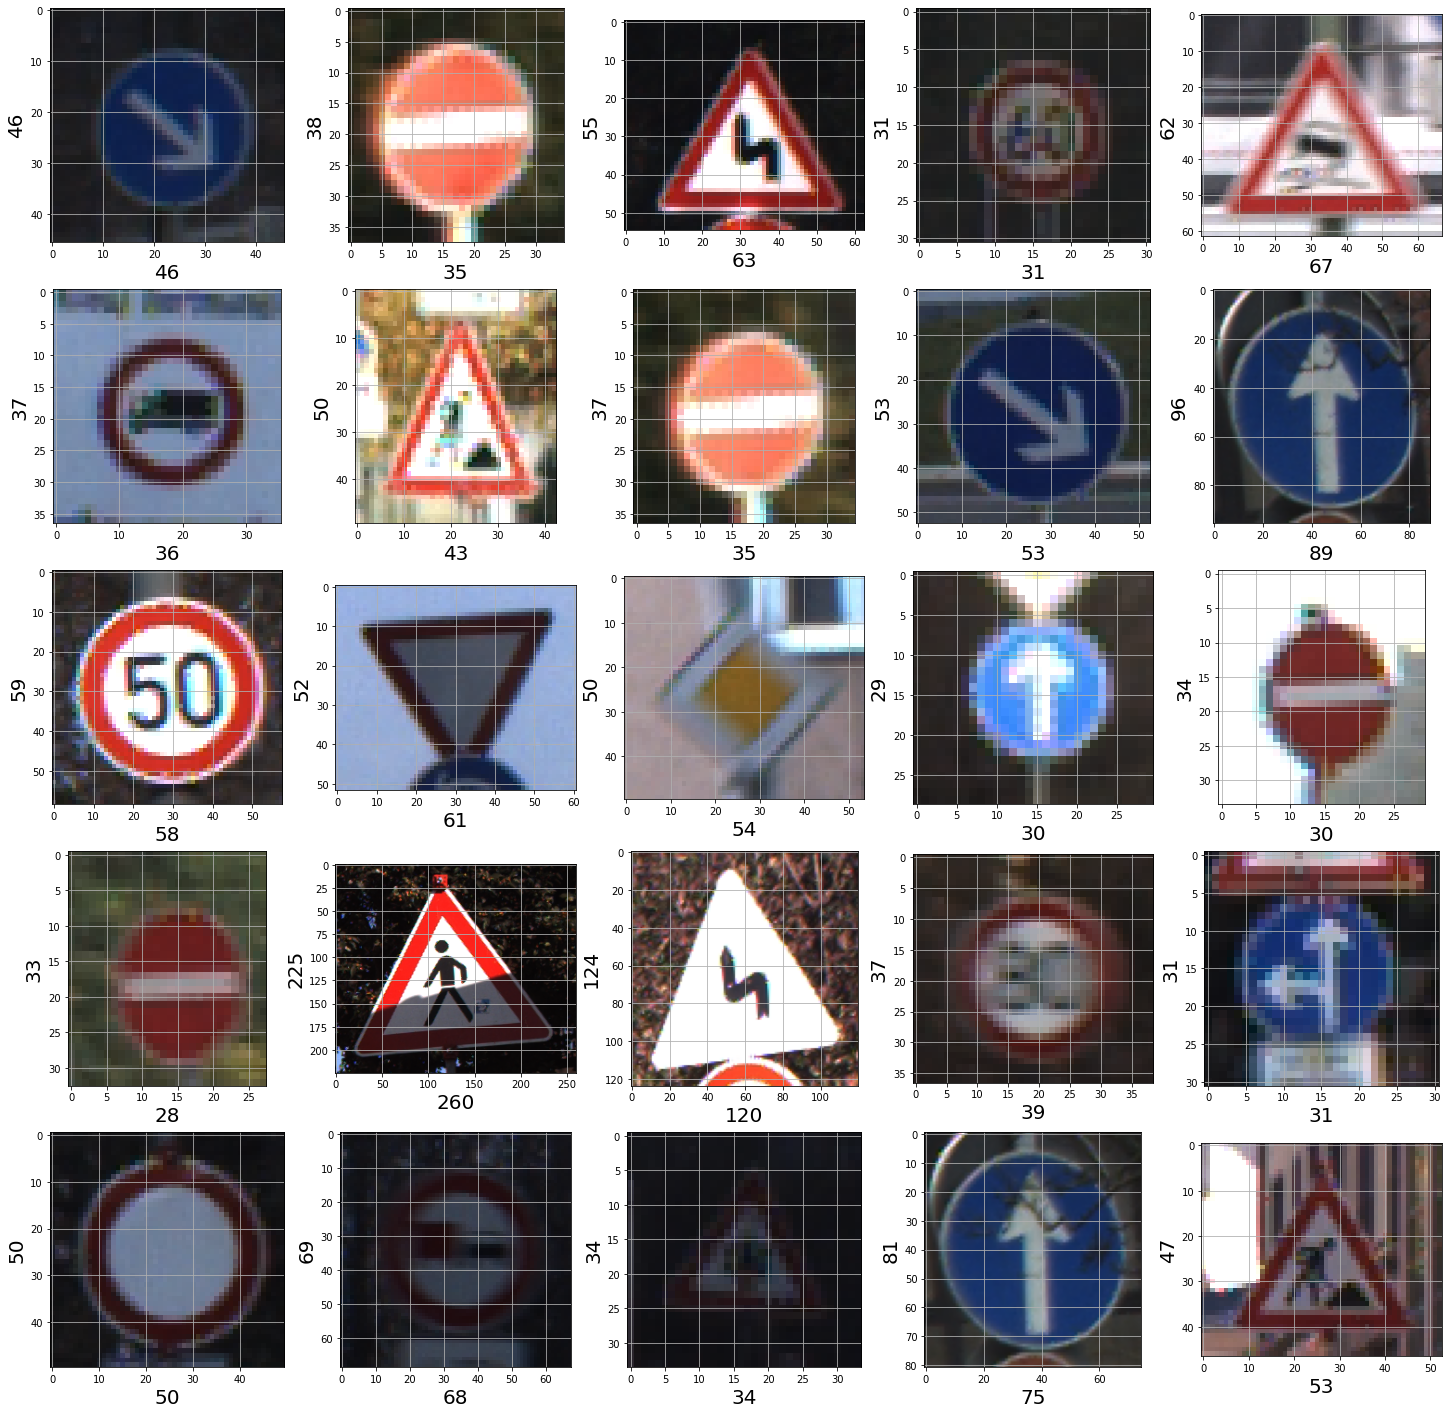

In [ ]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv('Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

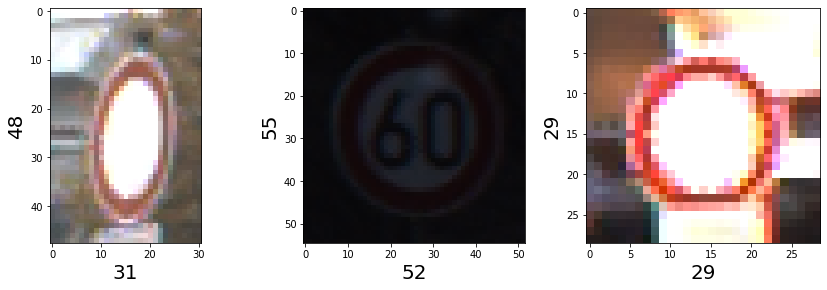

In [ ]:
test = pd.read_csv('Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,4):
    plt.subplot(5,5,i)
    random_img_path = random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image
    plt.savefig('gdrive/My Drive/data/sample_images3.png')

Setting up Validation and Test Directories.

In [ ]:
#Creating validation directory
val_dir = "Validation"
os.mkdir(val_dir)

n_classes = 43
train_dir = "Train{0}"

#Moving files from train to validation directory
for n in tqdm(range(n_classes)) :
  path = os.path.join(val_dir, str(n))
  os.mkdir(path)
  src_path = train_dir.format('/' + str(n))
  files = os.listdir(src_path)
  rand_idx = random.sample(range(len(files)), math.ceil(len(files)/5))
  for idx in rand_idx :
    src = src_path + "/" + files[idx]
    shutil.move(src, path)

100%|██████████| 43/43 [00:00<00:00, 150.89it/s]


In [ ]:
test_df = pd.read_csv('Test.csv')
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [ ]:
df =pd.read_csv("Test.csv")
df['Path'] = df['Path'].str.replace('Test/','')
df.to_csv('Test1.csv')
os.mkdir("Test2")

In [ ]:
# creating test directory
def prepare_test(path_to_image,path_file):

    with open(path_file,"r") as csvfile:
        r= csv.reader(csvfile,delimiter =',')
  
        for i,row in enumerate(r):
            if i == 0: 
                continue
            label = row[-2]
            img_name = row[-1]
            
            dest = os.path.join('Test2/',label)
            if not os.path.isdir(dest):
                os.makedirs(dest)
            
            to_move = os.path.join(path_to_image,img_name)
            shutil.copy(to_move,dest)

In [ ]:
import csv
path_to_image = "Test"
path_file ='Test1.csv'
prepare_test(path_to_image,path_file)

** Model I Hyperparameters**

In [ ]:
#Model I (same as H but with class weights)
batch_size = 256
lr = 0.0001
# 0.4 dropout layer before flatten
#0.2 dropout layer before output
#class weights

Data Preprocessing

In [ ]:
weights = {i:max(targ_cts)/targ_cts[i] for i in range(0,43)}
weights

{0: 10.714285714285714,
 1: 1.0135135135135136,
 2: 1.0,
 3: 1.5957446808510638,
 4: 1.1363636363636365,
 5: 1.2096774193548387,
 6: 5.357142857142857,
 7: 1.5625,
 8: 1.5957446808510638,
 9: 1.530612244897959,
 10: 1.1194029850746268,
 11: 1.7045454545454546,
 12: 1.0714285714285714,
 13: 1.0416666666666667,
 14: 2.8846153846153846,
 15: 3.5714285714285716,
 16: 5.357142857142857,
 17: 2.027027027027027,
 18: 1.875,
 19: 10.714285714285714,
 20: 6.25,
 21: 6.818181818181818,
 22: 5.769230769230769,
 23: 4.411764705882353,
 24: 8.333333333333334,
 25: 1.5,
 26: 3.75,
 27: 9.375,
 28: 4.166666666666667,
 29: 8.333333333333334,
 30: 5.0,
 31: 2.8846153846153846,
 32: 9.375,
 33: 3.265602322206096,
 34: 5.357142857142857,
 35: 1.875,
 36: 5.769230769230769,
 37: 10.714285714285714,
 38: 1.0869565217391304,
 39: 7.5,
 40: 6.25,
 41: 9.375,
 42: 9.375}

In [ ]:
#construct an instance of ImageDataGenerator class
image_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
#prepare iterators to loop through each and every image
training_iterator = image_datagen.flow_from_directory('Train', batch_size=batch_size, target_size=(224,224), seed=42)
validation_iterator = image_datagen.flow_from_directory('Validation', batch_size=batch_size, target_size=(224,224), seed=42)
test_iterator = image_datagen.flow_from_directory('Test2', batch_size=batch_size, target_size=(224,224), seed=42)

Found 31367 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


Setting up Model

In [ ]:
# instantiate VGG16 model
model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# specify the layers loaded are not trainable
for layer in model.layers:
    layer.trainable = False

In [ ]:
# Add dropout layer
first_drop_layer = layers.Dropout(0.4)(model.output)

# Flatten the output from second last fully connected layer in VGG
flatten_layer = layers.Flatten()(first_drop_layer)

#fully connected layer with 512 hidden units and ReLU activation
flat_fc_layer = layers.Dense(512, activation='relu')(flatten_layer)

# Add dropout layer
flat_fc_drop_layer = layers.Dropout(0.2)(flat_fc_layer)

#The last fully connected sigmoid layer with 43 neurons
flat_fc_soft_layer = layers.Dense(43, activation='softmax')(flat_fc_drop_layer)

In [ ]:
#define a new model with base VGG model combined with the new layers just created
model = Model(inputs=model.inputs, outputs=flat_fc_soft_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)


# ModelCheckpoint callback - save best weights
vgg16_checkpoint_1 = ModelCheckpoint(filepath='gdrive/My Drive/Models/vgg16_model_E.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
#Compile and fit the model

opt = Adam(learning_rate=lr)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model Training

In [ ]:
%%time 
history = model.fit(training_iterator, 
                    validation_data = validation_iterator,
                    epochs=30,
                    callbacks=[vgg16_checkpoint_1, early_stop],
                    verbose=1,
                    class_weight=weights)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 13.0782 - accuracy: 0.4226
Epoch 00001: val_loss improved from inf to 1.13365, saving model to gdrive/My Drive/Models/vgg16_model_I.weights.best.hdf5
123/123 [==============================] - 115s 730ms/step - loss: 13.0782 - accuracy: 0.4226 - val_loss: 1.1337 - val_accuracy: 0.6946
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 3.3994 - accuracy: 0.6699
Epoch 00002: val_loss improved from 1.13365 to 0.61482, saving model to gdrive/My Drive/Models/vgg16_model_I.weights.best.hdf5
123/123 [==============================] - 71s 576ms/step - loss: 3.3994 - accuracy: 0.6699 - val_loss: 0.6148 - val_accuracy: 0.8236
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 2.0762 - accuracy: 0.7699
Epoch 00003: val_loss improved from 0.61482 to 0.40141, saving model to gdrive/My Drive/Models/vgg16_model_I.weights.best.hdf5
123/123 [==============================] - 71s 572ms/step - loss

Save and Evaluate Model

In [ ]:
model.save('gdrive/My Drive/Models/transfer_vgg16_modelE.h5')


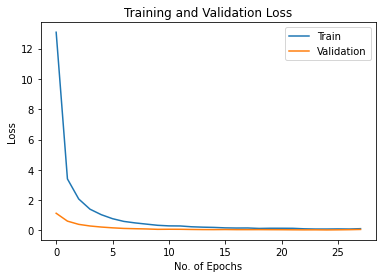

In [ ]:
import matplotlib.pyplot as plt

#plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['Train','Validation'],loc='upper right')
plt.savefig('gdrive/My Drive/Results/modelE_loss.png')
plt.show()

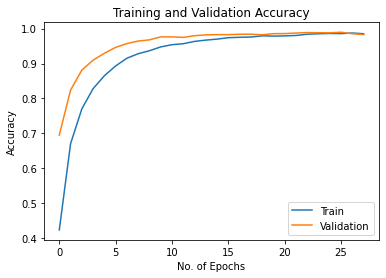

In [ ]:
#plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['Train','Validation'],loc='lower right')
plt.savefig('gdrive/My Drive/Results/modelE_accuracy.png')
plt.show()

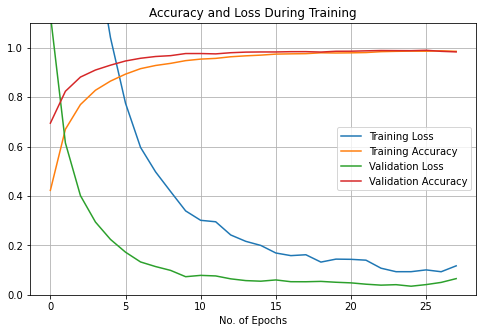

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.1)
plt.title('Accuracy and Loss During Training')
plt.legend(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
plt.xlabel('No. of Epochs')
plt.savefig('gdrive/My Drive/Results/modelE_loss_accuracy.png')
plt.show()

In [ ]:
print("validation set")
model.evaluate(validation_iterator)
print("test set")
model.evaluate(test_iterator)

validation set
31/31 [==============================] - 14s 441ms/step - loss: 0.0348 - accuracy: 0.9880
test set
50/50 [==============================] - 28s 552ms/step - loss: 0.8987 - accuracy: 0.8298


[0.8986933827400208, 0.8298495411872864]